# Fine-tuning the LLama 3.1 8B Model for 'Storybook' Story Generation Tasks using PEFT/LoRA on a Google Colab CUDA GPU Environment
Originally, this notebook was running on the TPUv2-8 GPU environment in Kaggle. However, LoRa fine-tuning capabilities are not yet accessible on a distributed environment. The pre-trained foundation model we are using is the gated meta-llama/Llama-3.2-1B-Instruct, requiring authentication with HuggingFace.

## Imports and Installs

In [1]:
from transformers import AutoProcessor
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from unsloth import FastLanguageModel
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

2025-02-12 07:08:19.241106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-12 07:08:19.313830: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-12 07:08:19.332600: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-12 07:08:19.635238: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
import torch
import xformers
print(f"PyTorch version: {torch.__version__}")
print(f"xFormers version: {xformers.__version__}")

PyTorch version: 2.5.1+cu121
xFormers version: 0.0.29.post1


In [3]:
import os
import pandas as pd
import numpy as np
import datasets
import torch 
import torch
import torch.nn as nn
#import torch_xla.test.test_utils as test_utils # Remove
#import torch_xla.experimental.xla_sharding as xs # Remove
#import torch_xla.core.xla_model as xm # Already imported as torch
from transformers import (
 AutoTokenizer, AutoModelForCausalLM, set_seed, DataCollatorWithPadding, AutoConfig
)

from transformers import logging as hf_logging
#import torch_xla.runtime as xr # Remove

#xr.use_spmd() # Remove

#from torch_xla.experimental.xla_sharding import Mesh # Remove

#from peft import LoraConfig, TaskType, get_peft_model
from datasets import  load_dataset, concatenate_datasets
from tqdm import tqdm

from torch.utils.data import Dataset as TorchDataset
#from torch_xla.utils.checkpoint import checkpoint # Remove or replace with torch.save

try:
    !export USE_TORCH=True
    #os.environ["PJRT_DEVICE"] = "TPU" # Remove
    os.environ["PJRT_DEVICE"] = "GPU" # Set to GPU instead of TPU
    #os.environ.pop('TPU_PROCESS_ADDRESSES') # Remove
    #os.environ.pop('CLOUD_TPU_TASK_ID') # Remove
    hf_logging.set_verbosity_error()
except:
    pass

## Loading the Tokenizer of the Pre-trained LlaMA 3.1 8B Natural Language Model
It's necessary to import the tokenizer of the model for loading the dataset.

In [ ]:
MAX_INPUT=1024 #128*32
MODEL = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit" #You should be able to use 7B model with no changes! There should be enough HBM
SAVED_MODEL = "Alexis-Az/Story-Generation-LlaMA-3.1-8B-10k"
# !export XLA_TENSOR_ALLOCATOR_MAXSIZE=1000000

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL) #use_fast=True if parallelized
if 'pad_token' not in tokenizer.special_tokens_map:
  tokenizer.pad_token=tokenizer.eos_token


print(f"Tokens :\n {tokenizer.special_tokens_map} \n\n")

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

Tokens :
 {'bos_token': '<|begin_of_text|>', 'eos_token': '<|eot_id|>', 'pad_token': '<|finetune_right_pad_id|>'} 




## Loading the Dataset

In [6]:
import math
from dataclasses import dataclass, field
from typing import List, Optional
from collections import defaultdict
import torch
import torch.nn as nn
import re
#import torch_xla.experimental.xla_sharding as xs # Remove
#import torch_xla.core.xla_model as xm # Remove
from transformers import LlamaConfig

# these are model architecture formatting rules specific to LLaMA - You might need to adjust these for CUDA
LLAMA_RULES = (
    ("model\\.embed_tokens", ("mp", "fsdp")),
    ("self_attn\\.(q_proj|k_proj|v_proj)", ("fsdp", "mp")),
    ("self_attn\\.o_proj", ("mp", "fsdp")),
    ("mlp\\.gate_proj", ("fsdp", "mp")),
    ("mlp\\.down_proj", ("mp", "fsdp")),
    ("mlp\\.up_proj", ("fsdp", "mp")),
    ("lm_head", ("fsdp", "mp")),
)

# You might need to redefine these for CUDA if you're using a sharding strategy
strkey2id = {
    "dp": 0,
    "fsdp": 1,
    "mp": 2
}

# This function might need significant changes for CUDA depending on your sharding strategy
def partition_module(model, mesh, device=torch.device("cuda"), verbose=False): # Changed device to cuda
    partition_specs = LLAMA_RULES
    rule = [(k, tuple([strkey2id[x] for x in v])) for k, v in partition_specs]

    for name, module in model.named_modules():
        module.to(device)

        # Adapt this logic for CUDA sharding
        if isinstance(module, (nn.Embedding, nn.Linear)):
            for rule_pattern, spec in rule:
                if re.findall(rule_pattern, name.lower()):
                    if verbose:
                        print("match", rule_pattern, name)

                    # Replace xs.mark_sharding with your CUDA sharding logic
                    # For example, using torch.distributed:
                    # torch.distributed.broadcast(module.weight, src=0) # Example - adjust as needed
                    break

In [7]:
from datasets import load_dataset

In [8]:
tinystories = "skeskinen/TinyStories-GPT4"
train_data = load_dataset(tinystories, split="train[:8000]").shuffle()
val_data = load_dataset(tinystories, split="train[8000:10000]").shuffle()

ConnectionError: Couldn't reach 'skeskinen/TinyStories-GPT4' on the Hub (ConnectTimeout)

In [ ]:
class InstructionDataset(TorchDataset):
    def __init__(self, tokenizer, max_length=1024, dataset=None):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        prompts = self.dataset[idx]
        text = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

        ### Instruction:
        {}

        ### Word List:
        {}

        ### Feature List:
        {}

        ### Summary:
        {}

        ### Story:
        {}"""
        instruction = ''
        words = ''
        features = ''
        summary = ''
        story = ''
        for prompt in prompts:
            data = prompts[prompt]
            if prompt == 'prompt':
                instruction = f"<|im_start|>user\n{data}<|im_end|>\n"
            if prompt == 'words':
                words = f"<|im_start|>user\n This is a list of words I want the story to include: {', '.join(data)}<|im_end|>\n"
            if prompt == 'features':
                features = f"<|im_start|>This is a list of story telling features I want the story to include: {', '.join(data)}<|im_end|>\n"
            if prompt == 'summary':
                summary = f"<|im_start|>assistant\n Here's a really short story (a summary): {data}<|im_end|>"
            if prompt == 'story':\
                story = f"<|im_start|>assistant\n Here's the full story:{data}<|im_end|>"
        text = text.format(instruction,words,features,summary,story)
        #print(text)




        #return {"text": text,}
        input_ids = self.tokenizer(text, add_special_tokens=True, max_length=self.max_length, truncation=True, padding="max_length", return_attention_mask=True, return_tensors="pt")
        return {
           "input_ids": input_ids["input_ids"].squeeze(0),
            "labels": input_ids["input_ids"].squeeze(0),
            "attention_mask":input_ids["attention_mask"].squeeze(0),
            "text":text
        }

In [ ]:
train_data

Dataset({
    features: ['story', 'summary', 'source', 'prompt', 'words', 'features'],
    num_rows: 8000
})

In [ ]:
val_data

Dataset({
    features: ['story', 'summary', 'source', 'prompt', 'words', 'features'],
    num_rows: 2000
})

In [ ]:
FLAGS = {'MAX_INPUT': MAX_INPUT,
         'LOGGING_STEPS': 1,
         'NUM_EPOCHS': 1,
         #'MAX_STEPS': -1,#Overides num epochs
         'BATCH_SIZE': 16, #Making batch_size lower then 8 will result in slower training, but will allow for larger models\context. Fortunately, we have 128GBs. Setting higher batch_size doesn't seem to improve time.
          'LEN_TRAIN_DATA': len(train_data),
         'VAL_STEPS': 20,
         'VAL_BATCH': 5,
         'GRAD_ACCUMULATION_STEP':1,
         'MAX_GRAD_CLIP':1,
        'LEARNING_RATE':6e-5,
         'WARMUP_RATIO':0.01,
         'OPTIMIZER':'adamw', # default = 'adamw'  options->  ['adamw']
         'SCHEDULER':'cosine', # default= 'cosine'     options:-> ['linear','cosine']
         'WEIGHT_DECAY':0.1,
         'TRAIN_DATASET':train_data,
         "TEST_DATASET":val_data,
         'WANDB':True,
        'PROJECT':'Storybook-Model',
        }

In [ ]:
train_data = InstructionDataset(tokenizer, dataset=train_data, max_length=FLAGS['MAX_INPUT'])
val_data = InstructionDataset(tokenizer, dataset=val_data)
training_loader = torch.utils.data.DataLoader(
    train_data, batch_size=FLAGS["BATCH_SIZE"], shuffle=True  # Add shuffle if needed
)
testing_loader = torch.utils.data.DataLoader(
    val_data, batch_size=FLAGS["BATCH_SIZE"], shuffle=False  # Usually no shuffle for validation
)
print(f"Max Steps: {len(training_loader)}, Batch size: {8*FLAGS['BATCH_SIZE']}")
print(f"Val Size: {len(testing_loader)}, Batch Size: {8*FLAGS['BATCH_SIZE']}")
FLAGS['STEPS']=len(training_loader)

Max Steps: 500, Batch size: 128
Val Size: 125, Batch Size: 128


In [ ]:
train_data[0]

{'input_ids': tensor([128004, 128004, 128004,  ...,   6345,     91,     29]),
 'labels': tensor([128004, 128004, 128004,  ...,   6345,     91,     29]),
 'attention_mask': tensor([0, 0, 0,  ..., 1, 1, 1]),
 'text': 'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n        ### Instruction:\n        <|im_start|>user\nWrite a short story (3-5 paragraphs) which only uses very simple words that a 3 year old child would understand. The story should use the verb "fix", the noun "cheese" and the adjective "useful". Remember to only use simple words!<|im_end|>\n\n\n        ### Word List:\n        <|im_start|>user\n This is a list of words I want the story to include: fix, cheese, useful<|im_end|>\n\n\n        ### Feature List:\n        <|im_start|>This is a list of story telling features I want the story to include: <|im_end|>\n\n\n        ### Summary:\n        <|im_start|>assistant\n

In [ ]:
import numpy as np
import random

# Define the sample size
sample_size = 3000  # Adjust as needed

# Create a random sample of indices
sample_indices = random.sample(range(len(train_data)), sample_size)

# Get text for the sample
text_list = [train_data[i]['text'] for i in sample_indices]

# tokenize the text list with the max_length set to none and truncation to false
input_ids_list = [tokenizer(text, add_special_tokens=True, max_length=None, truncation=False, return_attention_mask=True, return_tensors="pt")['input_ids'] for text in text_list]

In [ ]:
sequence_lengths = [tenso.numpy().shape[1] for tenso in input_ids_list]

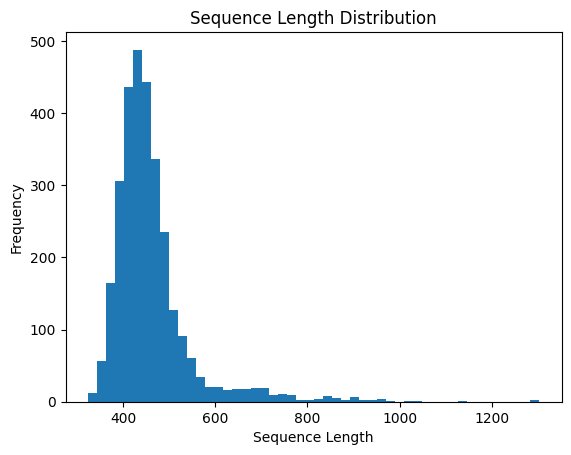

In [ ]:
import matplotlib.pyplot as plt

plt.hist(sequence_lengths, bins=50)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Sequence Length Distribution")
plt.show()

## Loading the Pre-trained Model with LoRa Adapters
Adding LoRa will allow us to fine-tune the model on our story dataset.

In [ ]:
model,tokenizer = FastLanguageModel.from_pretrained(MODEL, load_in_4bit=True)

==((====))==  Unsloth 2025.1.8: Fast Llama patching. Transformers: 4.47.1.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.0. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

In [ ]:
# Set device to CUDA if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the selected device
#model = model.to(device)

# Remove TPU-specific patching
# from torch_xla.distributed.fsdp.utils import apply_xla_patch_to_nn_linear
# model = apply_xla_patch_to_nn_linear(model, xs.xla_patched_nn_linear_forward)

# Remove TPU-specific device and mesh configuration
# num_devices = xr.global_runtime_device_count()
# model_axis=1
# data_axis=num_devices//model_axis
# mesh_shape = (1,data_axis, model_axis )
# device_ids = np.array(range(num_devices))
# mesh = Mesh(device_ids, mesh_shape, ('dp','fsdp', 'mp'))
# partition_module(model, mesh)

# If you need multi-GPU training with CUDA, consider using:
# import torch.nn.DataParallel as DataParallel
# if torch.cuda.device_count() > 1:
#    model = DataParallel(model)

# Print device information for confirmation
print(f"Using device: {device}")

Using device: cuda


## Training the Model

In [ ]:
import wandb
wandb_api = userdata.get("wandb_api")

wandb.login(key=wandb_api)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
import os
os.environ["WANDB_PROJECT"] = 'Storybook-Model'

In [ ]:
max_seq_length = 1024 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_data,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    disable_tqdm = False,
    packing = True, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 24,
        gradient_accumulation_steps = 2,
        warmup_steps = 5,
        #num_train_epochs = 1, # Set this for 1 full training run.
        #max_steps = 1000,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "StoryGen-FT-10000",
        report_to = "all", # Use this for WandB etc
    ),
)

In [ ]:
trainer.train()

Step,Training Loss
1,13.385300
2,13.325200
3,12.915600
4,11.608600
5,10.621900
6,9.768800
7,7.776900
8,7.549100
9,6.379700
10,6.002100


TrainOutput(global_step=501, training_loss=3.7695730117980593, metrics={'train_runtime': 6826.0551, 'train_samples_per_second': 3.516, 'train_steps_per_second': 0.073, 'total_flos': 1.112830925340672e+18, 'train_loss': 3.7695730117980593, 'epoch': 3.0})

## Saving the Fine-tuned Model on HuggingFace

In [ ]:
import time
print('Loading the model on CPU')
START=time.time()
model = model.cpu()
print(f"Loaded model on cpu in {time.time()-START} seconds ")

Loading the model on CPU
Loaded model on cpu in 3.859520435333252 seconds 


In [ ]:
SAVED_MODEL = "Alexis-Az/Story-Generation-LlaMA-3.1-8B-10k"
SAVED_MODEL_GGUF = "Alexis-Az/Story-Generation-LlaMA-3.1-8B-10k-GGUF"

In [ ]:
from huggingface_hub import login
login(hf_token) ##
model.push_to_hub(
    SAVED_MODEL,
    tokenizer=tokenizer,
    safe_serialization=True,
    create_pr=True,
    max_shard_size="3GB",
)

tokenizer.push_to_hub(
    SAVED_MODEL,
)

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Saved model to https://huggingface.co/Alexis-Az/Story-Generation-LlaMA-3.1-8B-10k


tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

In [ ]:
#saving the quantized model
model.push_to_hub_gguf(SAVED_MODEL_GGUF, tokenizer, quantization_method = "q4_k_m")